In [1]:
import cv2
import numpy as np
import glob
import json
import os
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import sys

sys.path.append(os.path.dirname(os.path.abspath('.')))
import utils.frame_slicing as frame_slicing

number_of_squares_x = 11
number_of_internal_corners_x = number_of_squares_x - 1
number_of_squares_y = 8
number_of_internal_corners_y = number_of_squares_y - 1
square_size = 0.023 # in meters
cameras = ['cam2', 'cam3', 'wide', 'cam0', 'cam1']

In [2]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
objp = np.zeros((number_of_internal_corners_x * number_of_internal_corners_y,3), np.float32)
objp[:,:2] = np.mgrid[0:number_of_internal_corners_x,0:number_of_internal_corners_y].T.reshape(-1,2)

In [3]:
def intrinsic_calibration(camera_name):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('screen_shots/*.png')

    shape = (0,0)

    effective_chessboard_count = 0
    total_chessboard_count = 0

    for fname in images:
        fname_parts = fname.split('/')[1].split('_')
        if fname_parts[0] != camera_name:
            continue
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        shape = gray.shape[::-1]

        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (number_of_internal_corners_x,number_of_internal_corners_y), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # print(f'{fname} pattern found')
            effective_chessboard_count += 1
        else:
            # print(f'{fname} pattern not found')
            pass
            
        total_chessboard_count += 1

    if (effective_chessboard_count < 10):
        raise ValueError(f'Not enough effective chessboard found: {effective_chessboard_count}/{total_chessboard_count}')

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    print(f'{camera_name} Effective Chessboard: {effective_chessboard_count}/{total_chessboard_count}')

    with open(f'results/intrinsic_{camera_name}.json', 'w') as f:
        json.dump({'mtx': mtx.tolist(), 'dist': dist.tolist()}, f)
        
    return mtx, dist

In [4]:
def extrinsic_calibration(mtxs, dists):

    images = glob.glob('screen_shots/*.png')

    effective_chessboard_count = 0
    total_chessboard_count = 0
    
    rvecs = []
    tvecs = []

    for image in images:
        cameras_ret = True
        if len(image.split('/')[1].split('_')) != 1:
            continue
        
        img = cv2.imread(image)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(gray)
        frames = [frame1, frame2, frame3, frame4, frame5]
        
        rvecs_temp = np.zeros((len(cameras), 3))
        tvecs_temp = np.zeros((len(cameras), 3))
        
        for camera in cameras:
            # Find the chess board corners
            ret, corners = cv2.findChessboardCorners(frames[cameras.index(camera)], (number_of_internal_corners_x,number_of_internal_corners_y), None)
        
            if ret == True:
                corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
                ret, rvec, tvec = cv2.solvePnP(objp, corners2, mtxs[cameras.index(camera)], dists[cameras.index(camera)])
                rvecs_temp[cameras.index(camera), :] = rvec[:, 0]
                tvecs_temp[cameras.index(camera), :] = tvec[:, 0]
            else:
                cameras_ret = False
            
        if cameras_ret:
            rvecs.append(rvecs_temp)
            tvecs.append(tvecs_temp)
            effective_chessboard_count += 1
        
        total_chessboard_count += 1
        
    print(f'Effective Chessboard: {effective_chessboard_count}/{total_chessboard_count}')
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)
    return rvecs, tvecs

In [5]:
def set_origin(rvecs, tvecs):
    for i in range(len(rvecs)):
        rves_camera3 = rvecs[i][2]
        tves_camera3 = tvecs[i][2]
        
        for j in range(len(rvecs[i])):
            rvecs[i][j] = rvecs[i][j] - rves_camera3
            tvecs[i][j] = tvecs[i][j] - tves_camera3
            
    return rvecs, tvecs

In [6]:
def remove_outliers(rvecs, tvecs):
    # TODO: Remove outliers
    rvecs = np.array(rvecs)
    tvecs = np.array(tvecs)
    rvecs_mean = np.mean(rvecs, axis=0)
    tvecs_mean = np.mean(tvecs, axis=0)
    return rvecs_mean, tvecs_mean

In [12]:
def visualize(rvec, tvec):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    for i in range(len(rvec)):
        orientation = np.array([1, 0, 0]) @ R.from_euler('xyz', rvec[i], degrees=False).as_matrix()
        ax.quiver(tvec[i][0], tvec[i][1], tvec[i][2], orientation[0], orientation[1], orientation[2], color = 'red', length=0.1)
        
    return fig

In [8]:
# images = glob.glob('screen_shots/*.png')

# for image in images:
#     image_name = image.split('/')[1]
#     img = cv2.imread(image)
#     frame1, frame2, frame3, frame4, frame5, frame6 = frame_slicing.slicing_frame(img)
#     cv2.imwrite(f"screen_shots/cam2_{image_name}", frame1)
#     cv2.imwrite(f"screen_shots/cam3_{image_name}", frame2)
#     cv2.imwrite(f"screen_shots/wide_{image_name}", frame3)
#     cv2.imwrite(f"screen_shots/cam0_{image_name}", frame4)
#     cv2.imwrite(f"screen_shots/cam1_{image_name}", frame5)

In [9]:
mtxs = np.zeros((len(cameras), 3, 3))
dists = np.zeros((len(cameras), 5))

for camera in cameras:
    mtx_cam, dist_cam = intrinsic_calibration(camera)
    mtxs[cameras.index(camera), :, :] = mtx_cam[0]
    dists[cameras.index(camera), :] = dist_cam[0]

cam2 Effective Chessboard: 29/48
cam3 Effective Chessboard: 34/48
wide Effective Chessboard: 46/48
cam0 Effective Chessboard: 28/48
cam1 Effective Chessboard: 23/48


In [10]:
rvecs, tvecs = extrinsic_calibration(mtxs, dists)

Effective Chessboard: 3/48


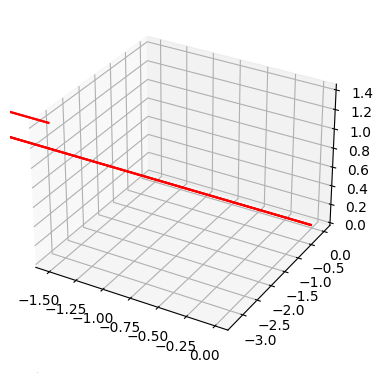

In [13]:
rvecs, tvecs = set_origin(rvecs, tvecs)
rvec, tvec = remove_outliers(rvecs, tvecs)
with open(f'results/extrinsic.json', 'w') as f:
    json.dump({'rvecs': rvecs.tolist(), 'tvecs': tvecs.tolist()}, f)
fig = visualize(rvec, tvec)
plt.show()